In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def get_class_from_filename(filename): # fix
    p = filename.split('/')[-1].split('_')
    return p[0] + '|' + p[1]


def get_class_id_from_filename(filename): # fix
    p = filename.split('/')[-1].split('_')
    if p[1] == "left":
        class_id = (int(p[0]) - 1) * 2
    else:
        class_id = 2 * int(p[0]) - 1
    return class_id


def get_all_filenames(root):
    filenames = []
    for file in os.listdir(root):
        if file.endswith('.bmp'):
            filenames.append(os.path.join(root, file))
    return filenames

In [ ]:
root = "/content/gdrive/MyDrive/Курсова/code/iris_files"
all_files = get_all_filenames(root)
classnames = list(map(get_class_from_filename, all_files))
class_ids = list(map(get_class_id_from_filename, all_files))

data_dct = {"filename": all_files, "classname": classnames, "class_id": class_ids}
df = pd.DataFrame(data_dct)
df.head(10)

,filename,classname,class_id
0,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
1,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
2,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
3,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
4,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
5,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
6,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
7,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
8,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
9,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

u, c = np.unique(df.class_id, return_counts = True)
y = u[c < 4]
for cl in y:
    ind = df.index[df.class_id == cl]
    df.drop(ind, axis=0, inplace=True)
df.shape

(380, 3)

In [ ]:
csv_train = []
csv_val = []

for class_id in np.unique(df.class_id):
    csv_sliced = df[df.class_id == class_id].sample(frac=1)
    csv_train.append(csv_sliced.iloc[:-2])
    csv_val.append(csv_sliced.iloc[-2:])
    
csv_train = pd.concat(csv_train, axis=0)
csv_val = pd.concat(csv_val, axis=0)

csv_train.head(10)

,filename,classname,class_id
0,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
4,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
2,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|left,0
6,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
5,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
7,/content/gdrive/MyDrive/Курсова/code/iris_file...,1|right,1
13,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|left,2
10,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|left,2
11,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|left,2
15,/content/gdrive/MyDrive/Курсова/code/iris_file...,2|right,3


In [ ]:
def get_random_rows_generator(_csv):
    def generator():
        unique_ids = np.unique(_csv.class_id)
        
        while True:
            anchor_class = np.random.choice(unique_ids)

            anchor_row = _csv[_csv.class_id == anchor_class].sample(1).iloc[0]
            positive_row = _csv[(_csv.class_id == anchor_row.class_id) & 
                                (_csv.filename != anchor_row.filename)].sample(1).iloc[0]
            negative_row = _csv[_csv.class_id != anchor_class].sample(1).iloc[0]

            anchor_file = anchor_row.filename
            positive_file = positive_row.filename
            negative_file = negative_row.filename

            yield anchor_file, positive_file, negative_file
    return generator


def prep_image(file):
    img_data = tf.io.read_file(file)
    img = tf.io.decode_bmp(img_data, channels=3)
    # gray = tf.image.rgb_to_grayscale(img)
    img /= 255
    return img


def prep_anp_images(fa, fp, fn):
    a = prep_image(fa)
    p = prep_image(fp)
    n = prep_image(fn)
    return a, p, n


def make_anp_dataset(_csv):
    ds = tf.data.Dataset.from_generator(get_random_rows_generator(_csv), output_types=(tf.string, tf.string, tf.string))
    ds = ds.map(prep_anp_images)
    return ds


ds_train = make_anp_dataset(csv_train)
ds_val = make_anp_dataset(csv_val)

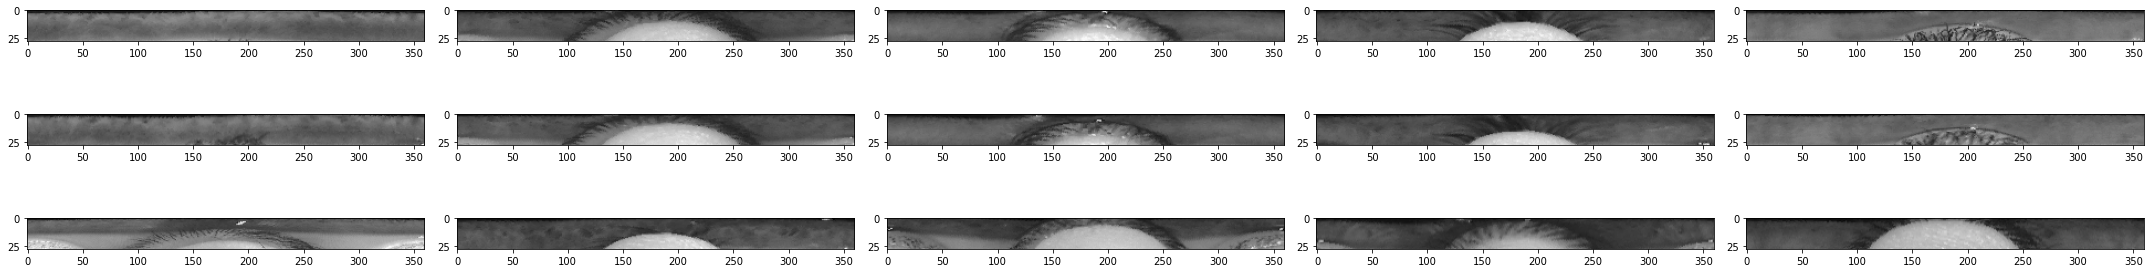

In [ ]:
samples = 5

fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 5))

for i, (img_a, img_p, img_n) in enumerate(ds_train.take(samples)):
    ax[0][i].imshow(img_a, cmap='gray')
    ax[1][i].imshow(img_p, cmap='gray')
    ax[2][i].imshow(img_n, cmap='gray')
    
fig.tight_layout()

In [ ]:
def ds_with_label(_csv):
    files = _csv.filename
    ds_files = tf.data.Dataset.from_tensor_slices(files)
    ds_label = tf.data.Dataset.from_tensor_slices(_csv.class_id.to_numpy())
    ds_files = ds_files.map(prep_image)
    ds = tf.data.Dataset.zip((ds_files, ds_label))
    return ds

ds_train_eval = ds_with_label(csv_train).batch(16, drop_remainder=False)
ds_val_eval = ds_with_label(csv_val).batch(16, drop_remainder=False)

def extract_descriptors(_ds):
    descriptors = []
    labels = []
    
    for batch_img, batch_label in _ds:
        batch_descriptors = m.predict(batch_img)
        batch_label = batch_label.numpy()
        descriptors.append(batch_descriptors)
        labels.append(batch_label)
        
    descriptors = np.concatenate(descriptors, axis=0)
    labels = np.concatenate(labels, axis=0)
        
    return descriptors, labels

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.m = tf.keras.Sequential([
            hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", trainable=False),  # Can be True, see below.
            
#             tf.keras.layers.Dense(1024, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128)
        ])
        
    def call(self, x):
        d = self.m(x)
        return d

In [ ]:
from tqdm.notebook import tqdm

def desc_cv_dist(descriptors, labels):
    classes = np.max(labels) + 1
    mymap = np.zeros([classes, classes])

    _d = descriptors.copy()
    _l = labels.copy()

    for i in  tqdm(range(len(labels))):
        distances = np.sqrt(np.mean((descriptors-_d)**2, axis=-1))

        for i in range(len(labels)):
            dist = distances[i]
            mymap[_l[i], labels[i]] += dist
            mymap[labels[i], _l[i]] += dist

        _d = np.roll(_d, shift=1, axis=0)
        _l = np.roll(_l, shift=1, axis=0)
    return mymap

In [ ]:
optimizer = tf.keras.optimizers.Adam()

bs = 64
ds_train_to_use = ds_train.batch(bs)
ds_val_to_use = ds_val.batch(bs)

m = Model()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.103 Pos: 0.066 Neg: 0.761 Dist: 0.6954888701438904
Val: Loss:   0.022 Pos: 0.019 Neg: 0.803 Dist: 0.783449113368988
Knn score: 0.22784810126582278
Knn score train: 0.9234234234234234


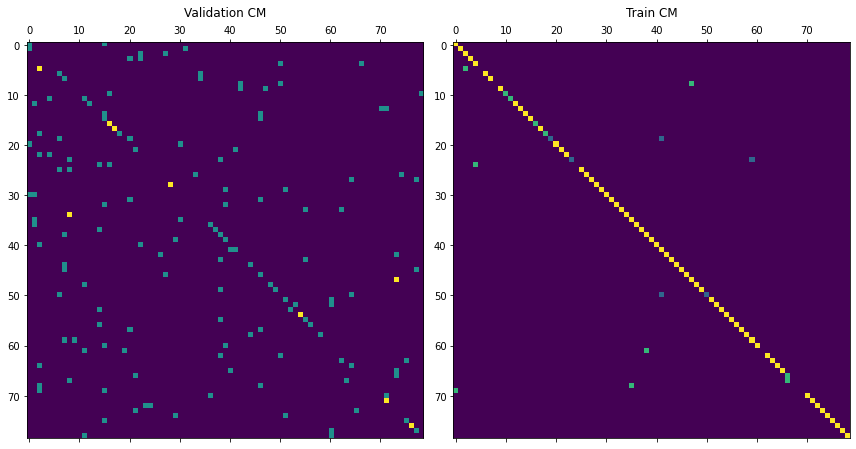

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

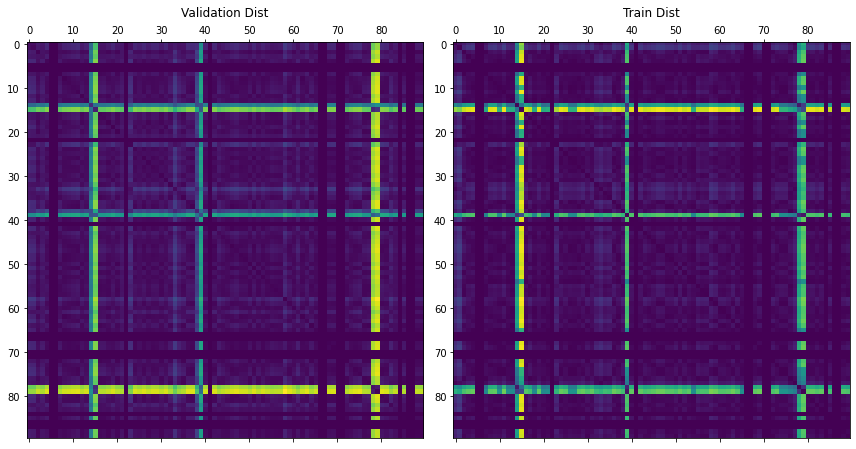

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.019 Pos: 0.017 Neg: 0.899 Dist: 0.8817360401153564
Val: Loss:   0.011 Pos: 0.011 Neg: 0.786 Dist: 0.7750377655029297
Knn score: 0.18354430379746836
Knn score train: 0.9009009009009009


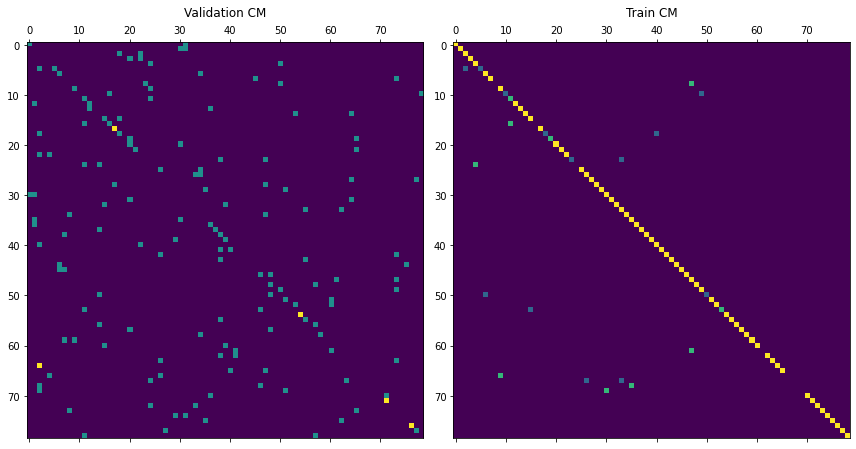

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

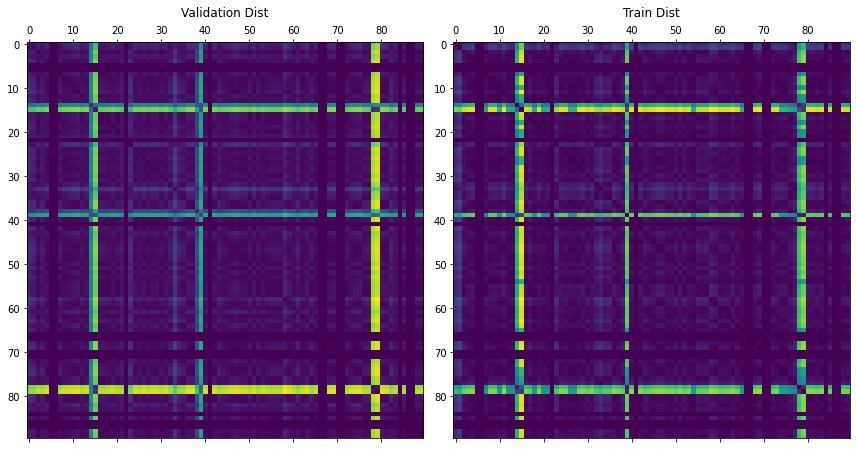

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.012 Pos: 0.011 Neg: 0.833 Dist: 0.821879506111145
Val: Loss:   0.016 Pos: 0.016 Neg: 0.856 Dist: 0.8405808806419373
Knn score: 0.18354430379746836
Knn score train: 0.8873873873873874


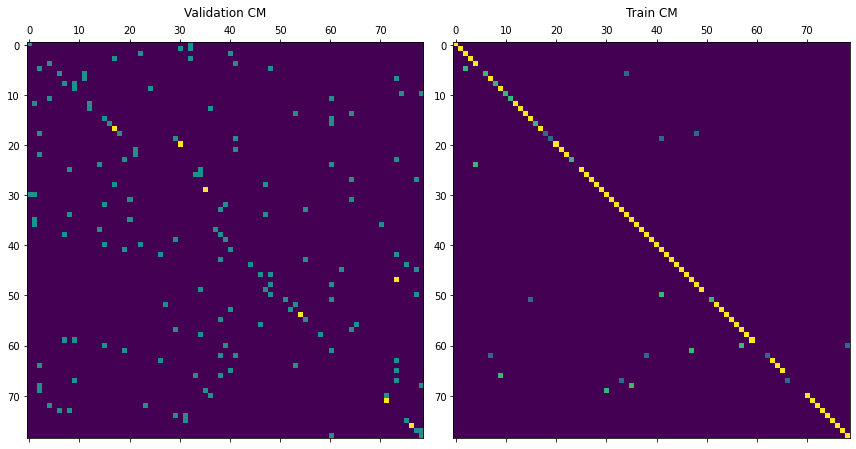

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

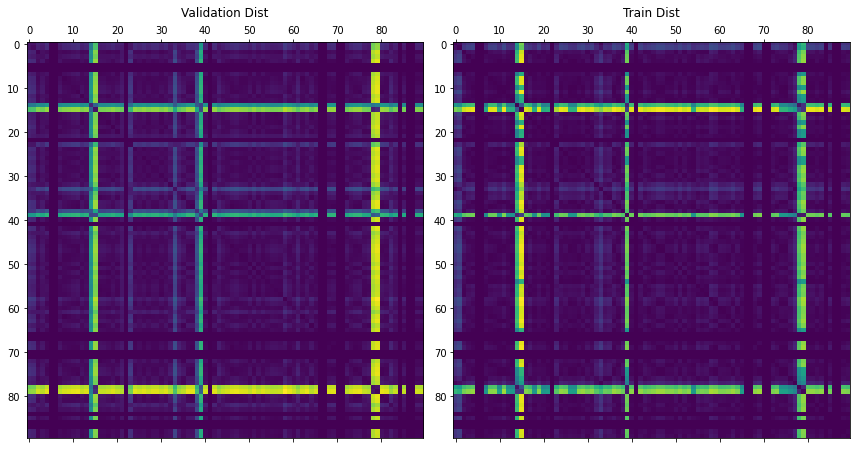

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.015 Pos: 0.013 Neg: 0.970 Dist: 0.9573537707328796
Val: Loss:   0.017 Pos: 0.017 Neg: 1.106 Dist: 1.088870644569397
Knn score: 0.13291139240506328
Knn score train: 0.8738738738738738


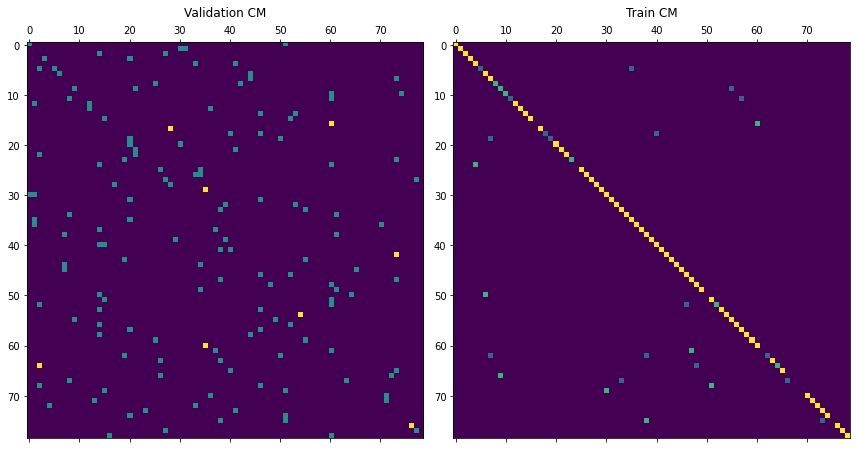

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

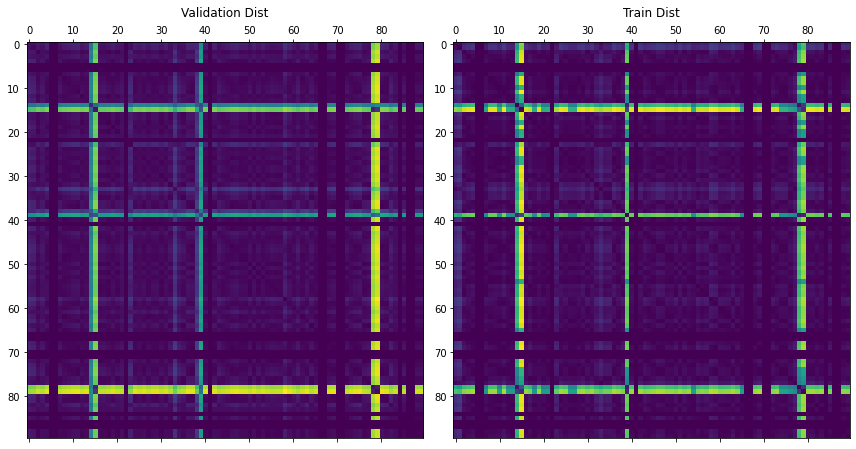

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.016 Pos: 0.013 Neg: 0.910 Dist: 0.8964476585388184
Val: Loss:   0.015 Pos: 0.015 Neg: 1.385 Dist: 1.3699803352355957
Knn score: 0.12658227848101267
Knn score train: 0.8378378378378378


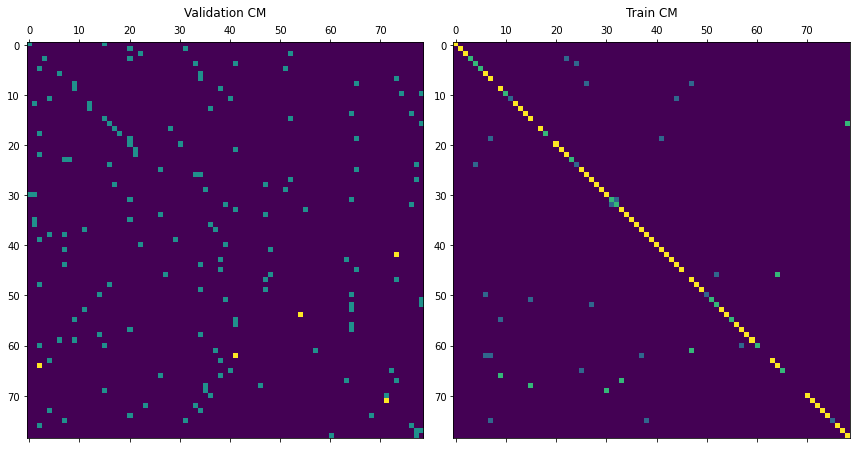

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

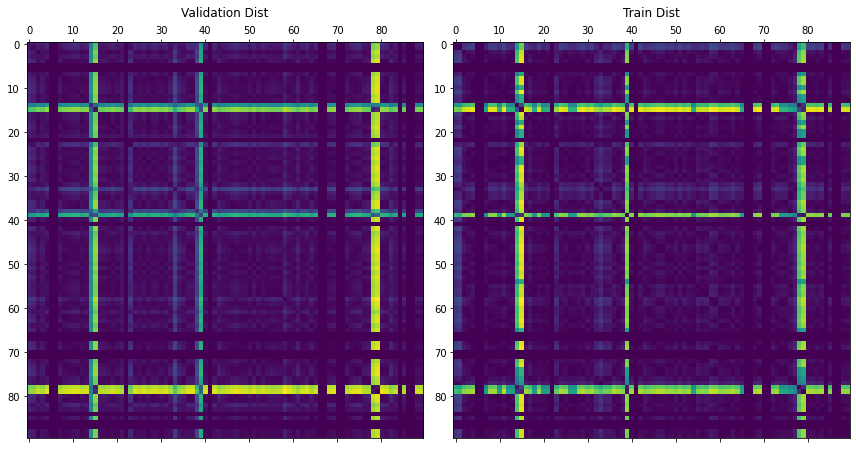

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.017 Pos: 0.013 Neg: 1.057 Dist: 1.0438995361328125
Val: Loss:   0.011 Pos: 0.011 Neg: 0.901 Dist: 0.889574408531189
Knn score: 0.14556962025316456
Knn score train: 0.8513513513513513


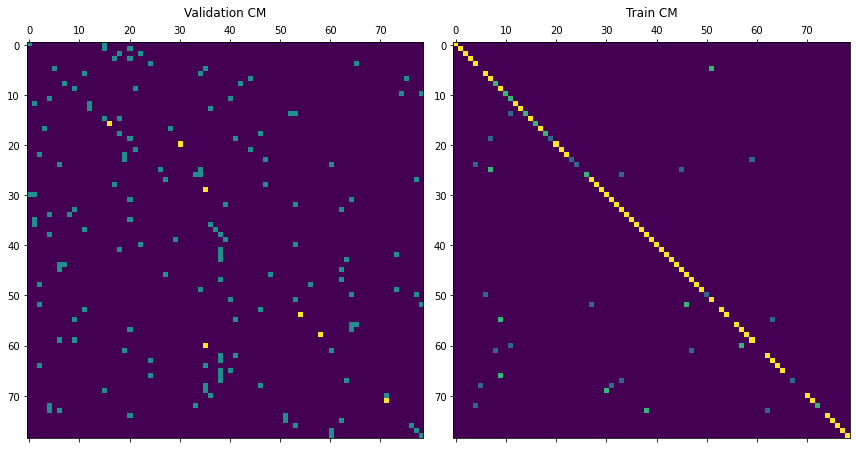

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

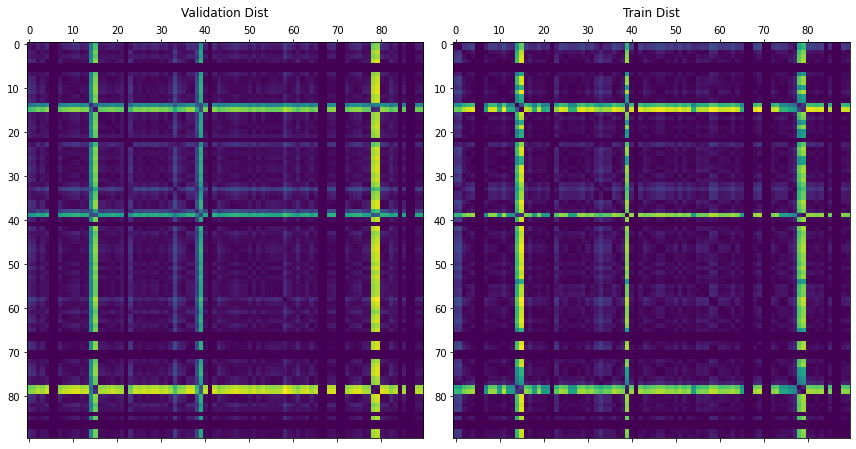

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.011 Pos: 0.010 Neg: 1.095 Dist: 1.0853300094604492
Val: Loss:   0.013 Pos: 0.013 Neg: 1.084 Dist: 1.070589303970337
Knn score: 0.1518987341772152
Knn score train: 0.8873873873873874


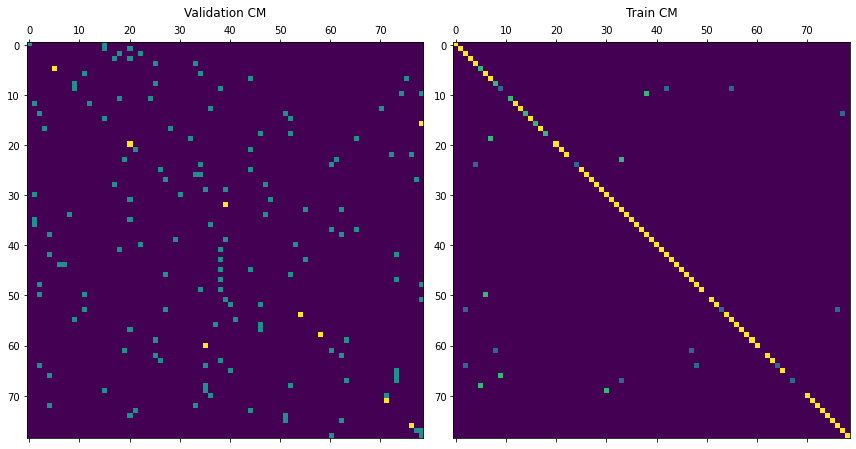

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

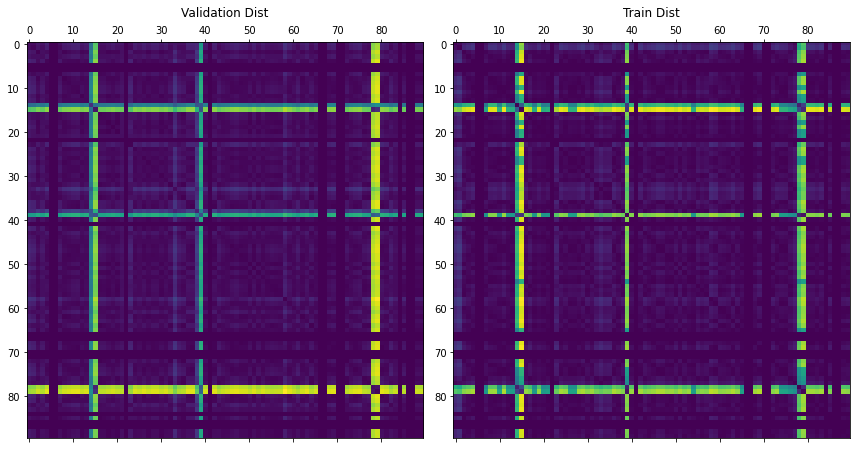

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.009 Pos: 0.009 Neg: 0.985 Dist: 0.9765405058860779
Val: Loss:   0.005 Pos: 0.005 Neg: 0.858 Dist: 0.8528268933296204
Knn score: 0.15822784810126583
Knn score train: 0.9144144144144144


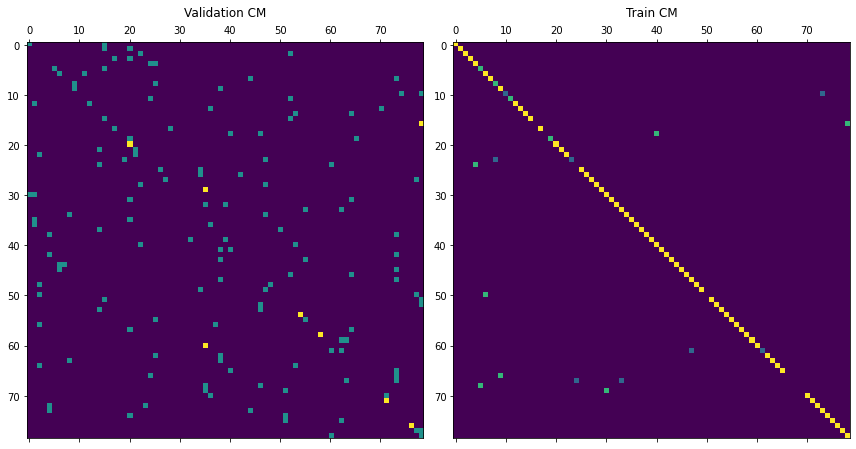

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

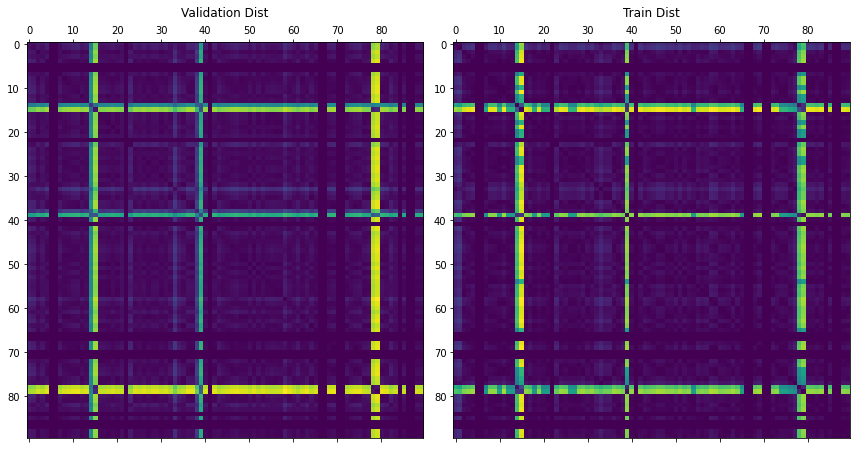

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.007 Pos: 0.006 Neg: 0.891 Dist: 0.8841697573661804
Val: Loss:   0.007 Pos: 0.007 Neg: 0.821 Dist: 0.814774751663208
Knn score: 0.17088607594936708
Knn score train: 0.9009009009009009


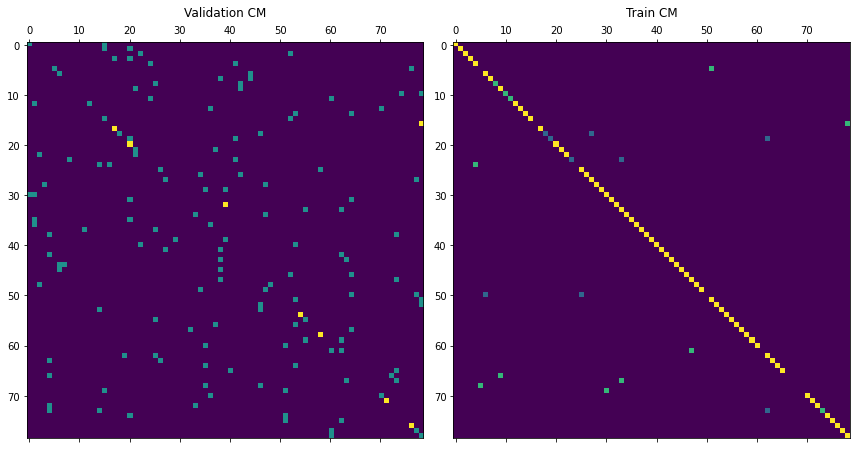

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

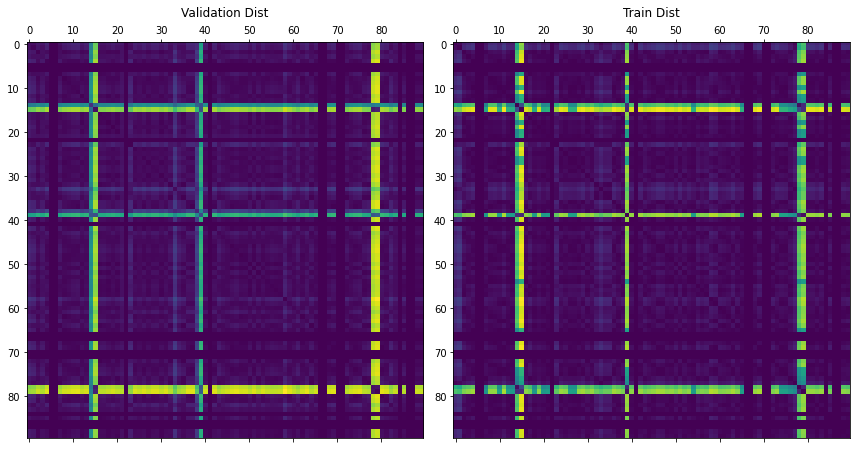

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Loss: 0.006 Pos: 0.006 Neg: 0.907 Dist: 0.9008733630180359
Val: Loss:   0.004 Pos: 0.004 Neg: 0.846 Dist: 0.8426463007926941
Knn score: 0.16455696202531644
Knn score train: 0.918918918918919


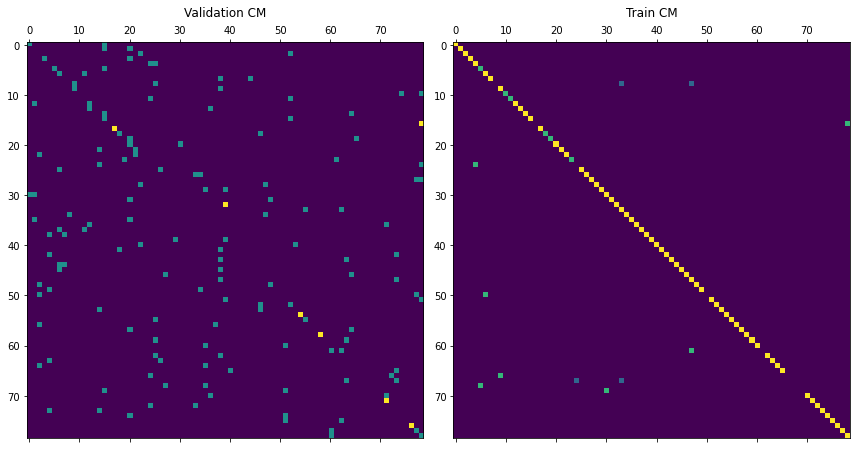

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

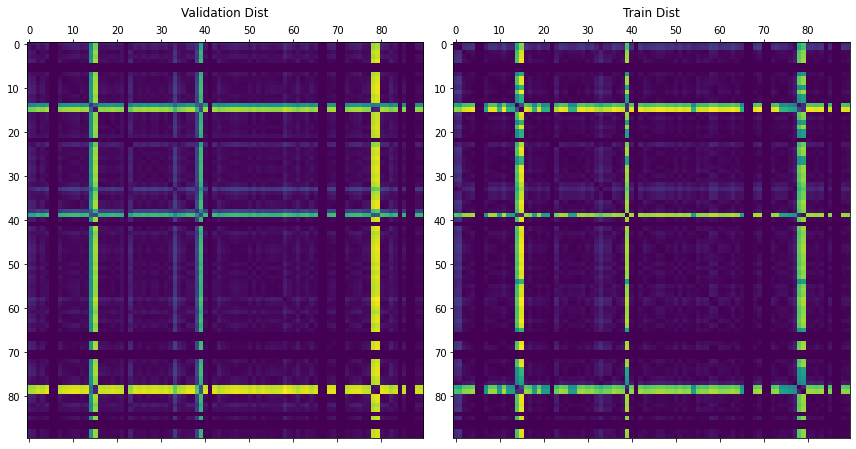

In [ ]:
import gc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
gc.collect()

def d(x, y):
    return tf.sqrt(tf.reduce_mean(tf.keras.losses.MSE(x, y)))

def run_epoch(_ds, steps, train=True):
    losses = []
    postitive_distances = []
    negative_distances = []
    
    margin = 0.5
    pbar = tqdm(_ds.take(steps), total=steps)
    for a, p, n in pbar:
        if train:
            with tf.GradientTape() as tape:
                da = m(a)
                dp = m(p)
                dn = m(n)

                pos_dist = d(da, dp)
                ned_dist = d(da, dn)
                l = tf.reduce_max([tf.reduce_mean(pos_dist - ned_dist + margin), 0])
                l += pos_dist
                grads = tape.gradient(l, m.trainable_weights)
                optimizer.apply_gradients(zip(grads, m.trainable_weights))
        else:
            da = m(a)
            dp = m(p)
            dn = m(n)

            pos_dist = d(da, dp)
            ned_dist = d(da, dn)
            l = tf.reduce_max([tf.reduce_mean(pos_dist - ned_dist + margin), 0])
            l += pos_dist

        losses.append(l.numpy())
        postitive_distances.append(pos_dist.numpy())
        negative_distances.append(ned_dist.numpy())
        
        mean_loss = np.mean(losses)
        pos_dist = np.mean(postitive_distances)
        neg_dist = np.mean(negative_distances)
        diff = neg_dist - pos_dist
        description = f'Loss: {mean_loss:0.3f} | P {pos_dist:0.3f} | N {neg_dist:0.3f} | D {neg_dist - pos_dist:0.3f}'
        pbar.set_description(description)
    return np.mean(losses), np.mean(postitive_distances), np.mean(negative_distances)
        

for i in range(10):
    train_loss, train_pos_d, train_neg_d = run_epoch(ds_train_to_use, steps=100)
    val_loss, val_pos_d, val_neg_d = run_epoch(ds_train_to_use, steps=20, train=False)
    print(f'Train: Loss: {train_loss:0.3f} Pos: {train_pos_d:0.3f} Neg: {train_neg_d:0.3f} Dist: {train_neg_d - train_pos_d}')
    print(f'Val: Loss:   {val_loss:0.3f} Pos: {val_pos_d:0.3f} Neg: {val_neg_d:0.3f} Dist: {val_neg_d - val_pos_d}')
    
    train_descriptors, train_labels = extract_descriptors(ds_train_eval)
    val_descriptors, val_labels = extract_descriptors(ds_val_eval)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_descriptors, train_labels)
    knn_score = knn.score(val_descriptors, val_labels)
    knn_score_train = knn.score(train_descriptors, train_labels)
    knn_predict = knn.predict(val_descriptors)
    knn_predict_train = knn.predict(train_descriptors)
    print(f'Knn score: {knn_score}')
    print(f'Knn score train: {knn_score_train}')
    

    cm = confusion_matrix(val_labels, knn_predict)
    cm_train = confusion_matrix(train_labels, knn_predict_train)
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
    ax[0].matshow(cm)
    ax[0].set_title('Validation CM')
    ax[1].matshow(cm_train)
    ax[1].set_title('Train CM')
    fig.tight_layout()
    plt.show()
    
    map_dist_train = desc_cv_dist(train_descriptors, train_labels)
    map_dist_val = desc_cv_dist(val_descriptors, val_labels)

    fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
    ax[0].matshow(map_dist_val)
    ax[0].set_title('Validation Dist')
    ax[1].matshow(map_dist_train)
    ax[1].set_title('Train Dist')
    fig.tight_layout()
    plt.show()